In [32]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data

#### Flu data

In [3]:
flu_df = pd.read_csv('data/flu_data.csv')
flu_df.head()

,date,Texas,Louisiana,Washington,New Jersey,Arkansas,Montana,North Dakota,Virgin Islands,Nebraska,...,Nevada,Idaho,Utah,Virginia,New York,District of Columbia,Oklahoma,South Dakota,New York City,Colorado
0,2010-40,2.06514,2.28108,0.510041,2.31534,0.696056,0.037119,0.671355,NaN,2.199780,...,1.66683,0.414938,0.747696,1.14343,0.262990,2.80877,0.624179,1.102750,1.18222,0.660684
1,2010-41,2.09394,2.04776,1.040070,2.47836,0.674157,0.180963,0.721961,NaN,2.735320,...,1.63633,1.457980,0.410939,1.23653,0.369729,2.89079,0.958678,0.793794,1.40230,0.628621
2,2010-42,2.10072,2.42974,0.904393,2.24812,0.514217,0.185874,0.567477,NaN,3.311030,...,1.50860,1.408140,0.440583,1.22545,0.362121,2.41042,2.070390,0.791023,1.29124,0.804020
3,2010-43,2.20655,1.92854,0.955110,2.79286,0.413650,0.036390,0.339239,NaN,2.057610,...,2.14451,1.280070,0.755957,1.26902,0.358981,3.11632,1.670730,0.801311,1.30236,0.909658
4,2010-44,2.36381,2.80934,0.786370,1.82877,1.090280,0.040519,0.713749,NaN,0.376712,...,1.76761,1.827240,0.651859,1.26547,0.527357,2.99118,1.628450,0.779833,1.51508,0.971705


#### Google Trend

In [4]:
texas_google = pd.read_csv('data/texas_google.csv')
texas_google.head()

,date,flu,treating flu,medicine for the flu,high fever,is the flu contagious,get over the flu,medicine for flu,how to get rid of the flu,fever cough,...,flu a symptoms,flu in children,do i have the flu,i have the flu,influenza incubation period,flu season,oscillococcinum,what is the flu,low body,remedies for the flu
0,2010-01-01,11,0,6,53,6,0,6,6,25,...,17,0,4,4,0,4,2,6,29,0
1,2010-02-01,9,0,6,32,6,7,7,7,23,...,0,9,0,2,0,2,3,6,39,0
2,2010-03-01,6,6,0,39,6,0,0,0,15,...,12,0,8,2,0,0,2,8,32,0
3,2010-04-01,6,0,0,74,0,0,13,0,13,...,4,0,0,2,2,3,2,17,19,0
4,2010-05-01,3,0,0,71,0,0,0,0,13,...,0,4,0,2,0,0,2,4,30,4


In [5]:
newyork_google = pd.read_csv('data/newyork_google.csv')
newyork_google.head()

,date,flu,treating flu,medicine for the flu,high fever,is the flu contagious,get over the flu,medicine for flu,how to get rid of the flu,fever cough,...,cold vs. flu,flu in children,do i have the flu,i have the flu,influenza incubation period,flu season,oscillococcinum,what is the flu,low body,remedies for the flu
0,2010-01-01,19,0,0,24,0,0,0,0,55,...,2,9,2,3,0,3,0,10,39,0
1,2010-02-01,11,7,0,36,7,0,8,0,16,...,0,5,0,0,0,0,0,25,40,0
2,2010-03-01,7,7,0,49,0,7,0,0,15,...,2,0,2,6,0,9,3,5,37,0
3,2010-04-01,5,0,0,34,14,0,0,0,15,...,0,5,0,3,0,3,0,5,29,0
4,2010-05-01,4,0,7,39,0,0,0,8,16,...,0,0,0,0,0,0,0,5,30,0


In [6]:
def normalize_google_trend(google_df):
    for col in google_df.columns[1:]: 
        google_df[col] = (google_df[col]-google_df[col].min())/(google_df[col].max()-google_df[col].min())
    return google_df

In [7]:
# normalize google trend data
texas_google_nor = normalize_google_trend(texas_google)
newyork_google_nor = normalize_google_trend(newyork_google)

In [8]:
# focus on Texas(low population density) and New York(high density) for now
df_texas = flu_df[['date', 'Texas']].merge(texas_google_nor, how = 'left', on='date')
df_texas = df_texas.fillna(0) # assuming no data means no search
df_texas.head()

,date,Texas,flu,treating flu,medicine for the flu,high fever,is the flu contagious,get over the flu,medicine for flu,how to get rid of the flu,...,flu a symptoms,flu in children,do i have the flu,i have the flu,influenza incubation period,flu season,oscillococcinum,what is the flu,low body,remedies for the flu
0,2010-40,2.06514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-41,2.09394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-42,2.10072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-43,2.20655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-44,2.36381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_newyork = flu_df[['date', 'New York']].merge(newyork_google_nor, how = 'left', on='date')
df_newyork = df_newyork.fillna(0) # assuming no data means no search
df_newyork.head()

,date,New York,flu,treating flu,medicine for the flu,high fever,is the flu contagious,get over the flu,medicine for flu,how to get rid of the flu,...,cold vs. flu,flu in children,do i have the flu,i have the flu,influenza incubation period,flu season,oscillococcinum,what is the flu,low body,remedies for the flu
0,2010-40,0.262990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-41,0.369729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-42,0.362121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-43,0.358981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-44,0.527357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

### Baseline

In [10]:
def baseline(state):
    values = flu_df[state].copy()
    size = int(len(values)*0.8) # 80% training
    train, test = values[:size], values[size:]
    preds = [train.values[-1]]*len(test)
    print('Test RMSE: ', np.sqrt(mean_squared_error(test, preds)))

In [11]:
baseline('Texas')

Test RMSE:  3.686933053215907


In [12]:
baseline('New York')

Test RMSE:  2.6943437069474916


In [13]:
def persistence(state, if_plot=True):
    
    # create a lagged representation
    values = flu_df[[state]] #dataframe
    df = pd.concat([values.shift(1), values], axis=1)
    df.columns = ['t-1', 't+1'] # use t-1 to predict t+1
    # split into train and test sets
    X = df.values
    train_size = int(len(X) * 0.8)
    train, test = X[1:train_size], X[train_size:]
    X_train, y_train = train[:,0], train[:,1]
    X_test, y_test = test[:,0], test[:,1]
    
    # model and predict
    preds = X_test
    mse = mean_squared_error(y_test, preds)
    print('Test RMSE: ', np.sqrt(mse))

    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_train, label='train')
        plt.plot([None for i in y_train] + [x for x in y_test], label='true test')
        plt.plot([None for i in y_train] + [x for x in preds], label='predict test')
        plt.legend()
        plt.show()

Test RMSE:  3.7435657380898952


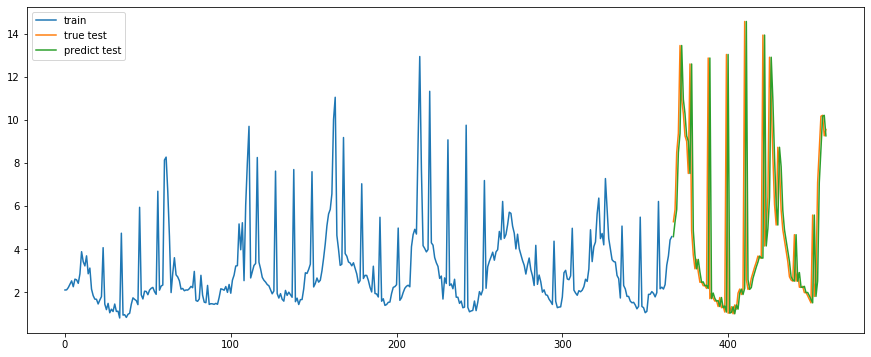

In [14]:
persistence('Texas')

In [15]:
persistence('New York', if_plot=False)

Test RMSE:  2.7919943357116086


### Linear Autoregression

In [16]:
def auto_regression(state, window, if_plot=True):
    # split dataset
    X = flu_df[state].values
    size = int(len(X)*0.8) # 80% training
    train, test = X[:size], X[size:]
    
    # train
    model = AutoReg(train, lags=window).fit()
    coef = model.params
    
    # predict
    history = train[len(train)-window:].tolist()
    preds = []
    for t in range(len(test)):
        N = len(history)
        lag = [history[i] for i in range(N - window, N)]
        yhat = coef[0]
        
        for w in range(window):
            yhat += coef[w+1] * lag[window-w-1]
            
        preds.append(yhat)
        history.append(test[t])
        
    print('Test RMSE: ', np.sqrt(mean_squared_error(test, preds)))
    
    # plot
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(test, label='true')
        plt.plot(preds, label='predicted')
        plt.legend()
        plt.show()      

Test RMSE:  2.475179397032585


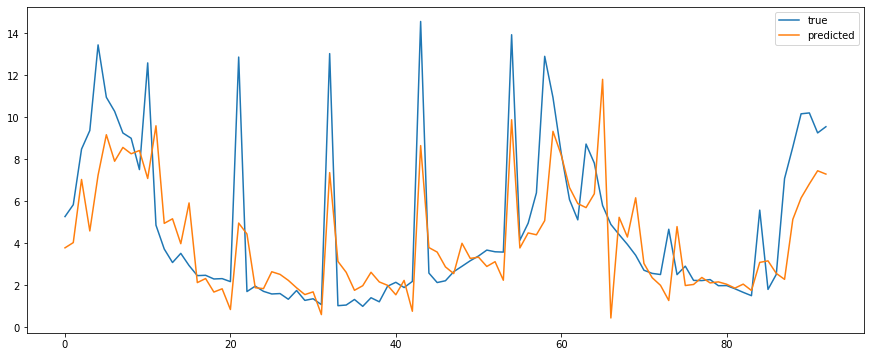

In [17]:
auto_regression('Texas', 15)

In [18]:
auto_regression('New York', 15, if_plot=False)

Test RMSE:  2.0117735842410793


### Linear Autoregression with Google Trend

###To do: ARGO

In [19]:
def ar_with_gt(df, lag, if_plot=True):
    # get train test
    flu, ft = pd.DataFrame(df.iloc[:, 1]), df.iloc[:, 2:]
    for i in range(lag):
        flu['lag {}'.format(i)] = flu.iloc[:, 0].shift(i+1)
    flu = flu.fillna(0) 
    
    X = pd.concat([flu.iloc[:, 1:], ft], axis = 1)
    y = flu.iloc[:, 0]
    
    size = int(len(df)*0.8) # 80% training
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    # model
    ridge = Ridge().fit(X_train, y_train)
    pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print('RMSE: ', rmse)
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(pred, label='predicted')
        plt.legend()
        plt.show() 
        
    return rmse

RMSE:  2.6084698769317383


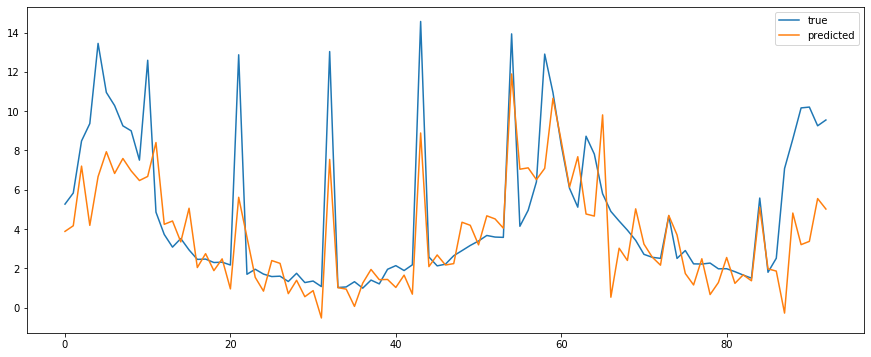

2.6084698769317383

In [20]:
ar_with_gt(df_texas, 52)

In [21]:
ar_with_gt(df_newyork, 52, if_plot=False)

RMSE:  1.9372087306191614


1.9372087306191614

### Linear Network Autoregression

In [22]:
def lnar(predict, target, lag, if_plot=True):
    # get train test
    y, predictors = flu_df[target], flu_df[predict]
    
    lag_series = []
    for i in range(lag):
        for col in predictors.columns:
            lag_series.append(predictors[col].shift(i+1).fillna(0))
    
    X = pd.concat(lag_series, axis = 1) 
    size = int(len(flu_df)*0.8) # 80% training
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    # model
    ridge = Ridge().fit(X_train, y_train)
    pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print('RMSE: ', rmse)
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(pred, label='predicted')
        plt.legend()
        plt.show() 
        
    return rmse

RMSE:  3.4766313820772288


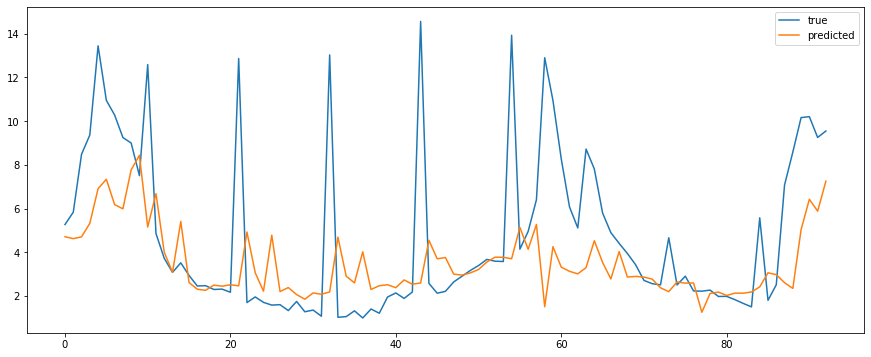

3.4766313820772288

In [23]:
# Use surrounding states as predictors
lnar(['New Mexico', 'Colorado', 'Oklahoma', 'Louisiana', 'Arkansas'], 'Texas', 4, if_plot=True)

In [24]:
# Use surrounding states as predictors
lnar(['Pennsylvania', 'New Jersey', 'Connecticut', 'Massachusetts', 'Vermont'], 'New York', 4, if_plot=False)

RMSE:  2.262704055765882


2.262704055765882

### ARIMA

In [25]:
def arima(state, lag, if_plot=True):
    # split dataset
    X = flu_df[state].values
    size = int(len(X)*0.8) # 80% training
    train, test = X[:size], X[size:]
    
    # fit and predict
    history = train.tolist()
    preds = []
    for t in range(len(test)):
        model = ARIMA(history, order=(lag,1,5)).fit(disp=False)
        output = model.forecast()

        preds.append(output[0])
        history.append(test[t])
        
    print('Test RMSE: ', np.sqrt(mean_squared_error(test, preds)))
    
    # plot
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(test, label='true')
        plt.plot(preds, label='predicted')
        plt.legend()
        plt.show()      

Test RMSE:  3.132786806762247


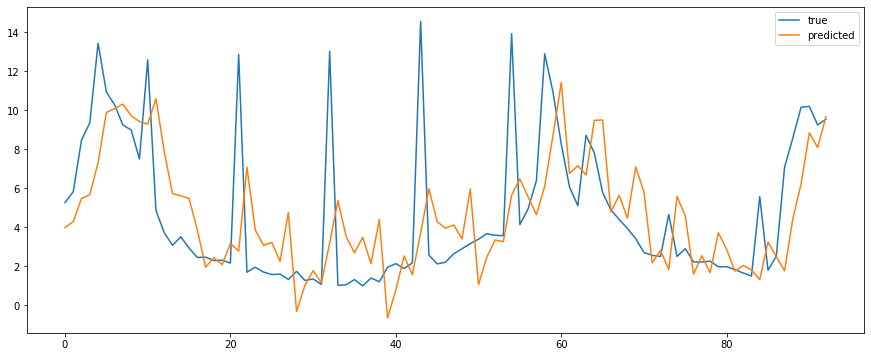

In [26]:
arima('Texas', 5)

### Random Forest

In [27]:
def random_forest(target, predictors, gt_df=None, if_plot=True):
    #data
    X, y = flu_df[predictors], flu_df[target]
    size = int(len(flu_df)*0.8) # 80% training
    
    if gt_df is not None:
        col = ['date'] + predictors
        X_df = flu_df[col].merge(gt_df, how='left', on='date').fillna(0)
        X = X_df.iloc[:, 1:]
    
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    rf = RandomForestRegressor(n_estimators=50, random_state=0)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(pred, label='predicted')
        plt.legend()
        plt.show() 

Test RMSE:  1.737816981544222


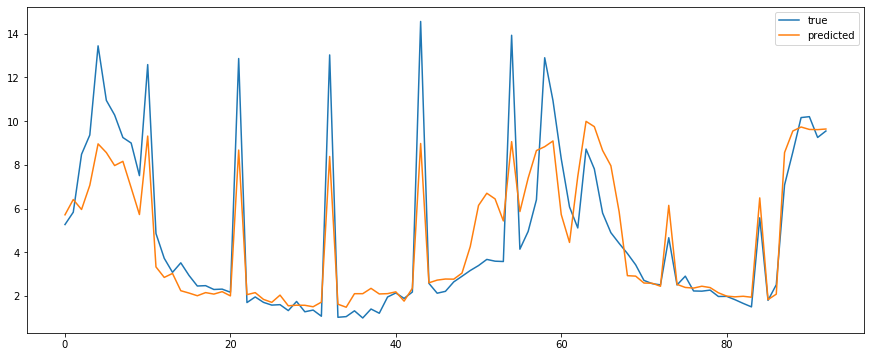

In [28]:
# without Google trend
random_forest('Texas', ['New Mexico', 'Colorado', 'Oklahoma', 'Louisiana', 'Arkansas'])

Test RMSE:  1.728452586192139


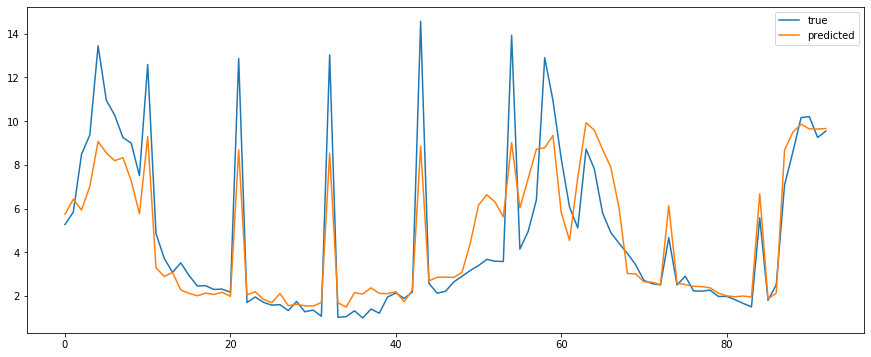

In [29]:
# with Google trend
random_forest('Texas', ['New Mexico', 'Colorado', 'Oklahoma', 'Louisiana', 'Arkansas'], gt_df=texas_google_nor)

Test RMSE:  1.4255641910518608


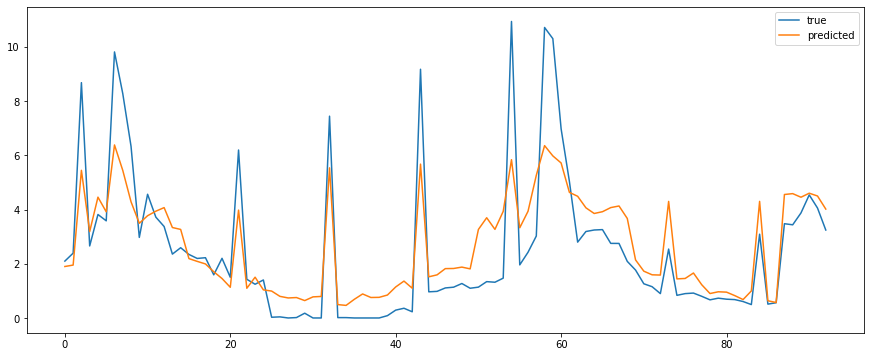

In [30]:
# without Google trend
random_forest('New York', ['Pennsylvania', 'New Jersey', 'Connecticut', 'Massachusetts', 'Vermont'])

Test RMSE:  1.4197333004406878


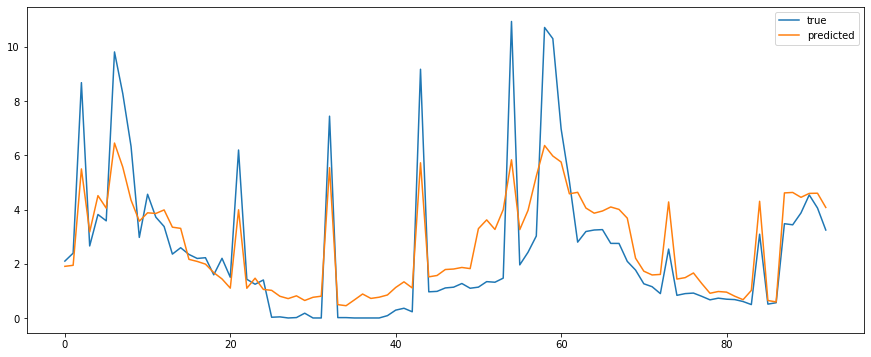

In [31]:
# with Google trend
random_forest('New York', ['Pennsylvania', 'New Jersey', 'Connecticut', 'Massachusetts', 'Vermont'], gt_df=texas_google_nor)

### RNN

#### Vanilla RNN


Test RMSE:  0.9128406942678609


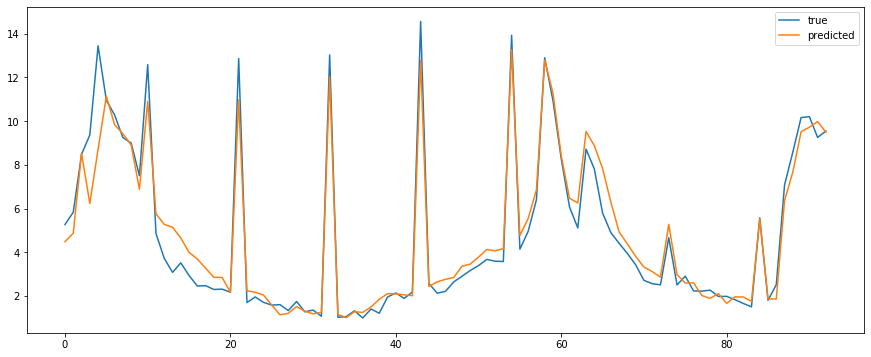

In [71]:
def NN(X_train,y_train,batch_size,epochs,verbose):
    n_units = 100
    drop_rate = .1
    dim_embed = 50
    optimizer = "rmsprop"
    loss = "mse"
    batch_size = batch_size
    epochs = epochs
    validation_split = 0.1
    verbose = verbose
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(input_dim=len(X_train.keys()),units = 64,activation = 'relu'))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(units = 64,activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss=loss)
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)
    return model
            

def VanillaNN(state,if_plot=True):
    #data
    X = flu_df.drop(columns = [state,'date','Virgin Islands','Puerto Rico'])
    y = np.asarray(flu_df[state])
    size = int(len(flu_df)*0.8) # 80% training
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    nn = NN(X_train,y_train,32,10,0)
    pred = nn.predict(X_test)
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(pred, label='predicted')
        plt.legend()
        plt.show() 

VanillaNN('Texas',if_plot=True)

Test RMSE:  3.781414599843742


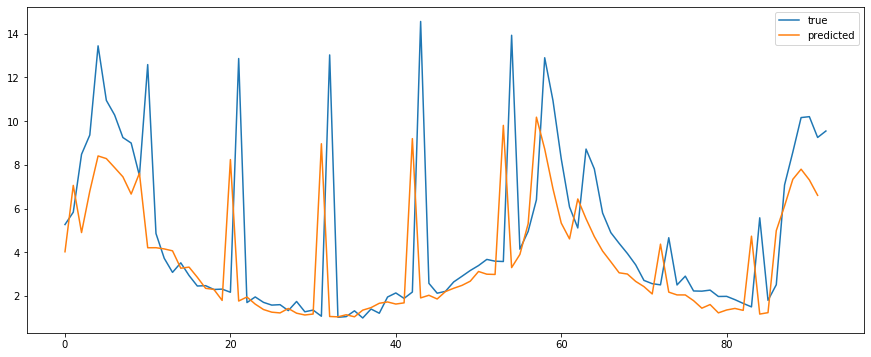

In [69]:
def VanillaNN2(state,if_plot=True):
    #data
    X = flu_df.drop(columns = [state,'date','Virgin Islands','Puerto Rico'])
    y = flu_df[state]
    size = int(len(flu_df)*0.8) # 80% training
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    preds = []
    for t in range(len(y_test)):
        nn = NN(X_train,y_train,32,10,0)
        pred = nn.predict(X_test)
        preds.append(pred[0])
        X_train, X_test = X[:size+1], X[size+1:]
        y_train,_ = y[:size+1], y[size+1:]

        
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(pred, label='predicted')
        plt.legend()
        plt.show() 

VanillaNN2('Texas',if_plot=True)

#### GRU

#### LSTM